[View in Colaboratory](https://colab.research.google.com/github/rdorff/Data/blob/master/Lab2.ipynb)

In [0]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
 
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

In [0]:
class LinearNetwork(nn.Module):
  """Base class 
  """
  def __init__(self, dataset):
    super(LinearNetwork, self).__init__()
    x, y = dataset[0]
    c, h, w = x.size()
    out = y.size(0)
    
    self.net = nn.Sequential(nn.Linear(c*h*w,out))
    
  def forward(self, x):
    n, c, h, w = x.size()
    flattened = x.view(n, c*h*w)
    return self.net(flattened)
    
class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data=datasets.FashionMNIST(root, train=train,
                           transform=transforms.ToTensor(),
                           download=True)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y.unsqueeze(0).float()
  
  def __len__(self):
    return 42 #len(self.data)

    
# Initialize Training Data and Model
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist/',train=True)
model = LinearNetwork(train_dataset)
model = model.cuda()
objective = torch.nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset,
                         batch_size=42,
                         pin_memory=True)
train_losses = []

# Initialize Validation Data
validation_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist/',train=False)
validation_loader = DataLoader(validation_dataset,
                              batch_size=42,
                              pin_memory=True)
validation_losses = []

# Loop through data 500 times
for epoch in range(500):
  
#  loop = tqdm(total=len(train_loader), position=0)
  # Train Data
  for x, y_truth in train_loader:
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    optimizer.zero_grad()

    y_hat = model(x)
    loss = objective(y_hat, y_truth)
   
    train_losses.append(loss)
    
#    loop.set_description('loss:{:.4f}'.format(loss.item()))
#    loop.update(1)
    
    loss.backward()
    optimizer.step()
    
  # Validate Data
  for x, y_truth in validation_loader:
    x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
    
    y_hat = model(x)
    loss = objective(y_hat, y_truth)
    
    validation_losses.append(loss)
#loop.close()


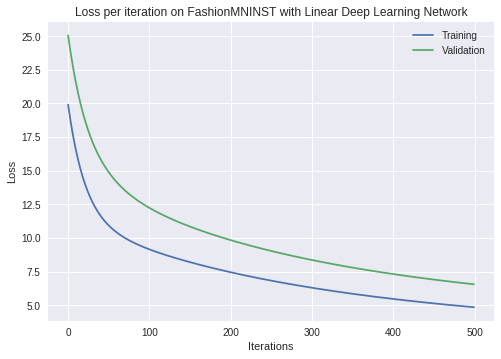

In [77]:
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss per iteration on FashionMNINST with Linear Deep Learning Network')
plt.legend()